# <span style="color:green"> A.I. Gym Trainer 💪 </span>
Hello there, thank you for using our AI gym trainer program. 
<br/><br/>
Just like a personal gym trainer, we aim to help you keep track of the number of exercise repetition you performed, along with a pose correction feedback mechanism to correct your pose if needed. 
<br/>
At the end of your exercise, a chart will be displayed to show you your performance throughout the exercise. 📈

Exercises supported: Squats, Arm Curl, Situp
***

    Note. This is a Monash University final year project completed by Kai Lin Wong, Eu Yang Chai and Kee Hong Tan; 
    under the supervision of Dr Raphael Phan; completed in year 2021.


***

### <span style="color:red"> Make sure that you have enabled the camera on your computer before proceeding. 💻 </span>
Instructions:
<span style="color:blue">    
    1. Click on the 'Kernel' tab above and select 'Restart and Run All'. <br/>
    2. When prompted input, enter either '1', '2', or '3' then hit the 'Enter' key to choose the exercise that you would like to perform. <br/>
    3. A new window will open up, make sure to select that window.     <br/>
    4. Proceed to perform your exercise infront of your webcam.  <br/> 
</span>     
<p style="color:red">  
    Make sure your whole body is visible in the frame when performing your exercise!   
</p>     

After your exercise session:
<span style="color:blue">    
    1. Press 'q' to stop the program.        
    2. A chart displaying your performance will appear at the bottom of the notebook. 
</span>    

In [1]:
# Install dependencies if haven't already
!pip install mediapipe opencv-python

In [2]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt

# draw landmarks & connections to screen
mp_drawing = mp.solutions.drawing_utils
# import Pose model
mp_pose = mp.solutions.pose

In [3]:
def calc_angle(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    radians = np.arctan2(z[1]-y[1], z[0]-y[0]) - np.arctan2(x[1]-y[1], x[0]-y[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [4]:
def recognise_curl(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global left_angle
    global right_angle
    
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # left arm
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y] 

        # right arm
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
        
        left_elbow_angle = calc_angle(left_shoulder, left_elbow, left_wrist)
        right_elbow_angle = calc_angle(right_shoulder, right_elbow, right_wrist)
        left_angle.append(int(left_elbow_angle))
        right_angle.append(int(right_elbow_angle))
        
        # down state
        if left_elbow_angle > 160 and right_elbow_angle > 160:
            if not range_flag:
                feedback = 'Did not curl completely.'
            else:
                feedback = 'Good rep!'
            state = 'Down'
            
        # not fully curled
        elif (left_elbow_angle > 50 and right_elbow_angle > 50) and state == 'Down':
            range_flag = False
            feedback = ''
            
        # up state
        elif (left_elbow_angle < 30 and right_elbow_angle < 30) and state == 'Down':
            state = 'Up'
            feedback = ''
            range_flag = True
            counter += 1
    
    except:
        left_angle.append(180)
        right_angle.append(180)

In [5]:
def recognise_squat(detection):
    
    global counter
    global state
    global feedback
    global left_angle
    global right_angle
       
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # GET COORDINATES
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
        
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

        left = calc_angle(left_hip, left_knee, left_heel)
        right = calc_angle(right_hip, right_knee, right_heel)        
        left_angle.append(int(left))
        right_angle.append(int(right))
        
        #POSE CHECKING 1: Knees bending inwards    
        shoulder_dist = left_shoulder[0] - right_shoulder[0]
        knee_dist = left_knee[0] - right_knee[0]

        if shoulder_dist - knee_dist > 0.04:
            feedback = 'Open up your knees further apart to shoulder width!'
        else:
            feedback = ''

        # standing up
        if left > 170 and right > 170:
            state = "Up"
            
        if left < 165 and right < 165:
            feedback = 'Almost there... lower until height of hips!'
            
        if left < 140 and right < 140 and state == "Up":
            state = "Down"
            counter += 1
            
        if state == "Down":
            feedback = 'Good rep!'
    
    except:
        left_angle.append(180)
        right_angle.append(180)

In [6]:
def recognise_situp(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global halfway
    global body_angles
    
    try: 
        landmarks = detection.pose_landmarks.landmark
        
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]

        # CALCULATE ANGLES 
        angle_knee = calc_angle(left_hip, left_knee, left_heel)
        angle_body = calc_angle(left_shoulder, left_hip, left_knee)
        body_angles.append(int(angle_body))
      
        if (angle_body < 80 and angle_body > 50) and state == "Down": #Half-way there (Used for checking bad situps)
            halfway = True

        if angle_body < 40 and state == "Down": #Complete situp
            state = "Up"
            range_flag = True
            
        if angle_body > 90 and angle_knee < 60: #Resting position;to check if situp was done properly
            state = "Down"
            
            if halfway: #Check if a rep was attempted
                if range_flag: #Check if a proper rep was performed
                    counter += 1
                    feedback = "Good repetition!"
                else:
                    feedback = "Did not perform sit up completely."
                range_flag = False #Reset vars
                halfway = False
                
        if angle_knee > 70: #Triggers anytime the legs are not tucked in
            feedback = "Keep legs tucked in closer"

    except: 
        body_angles.append(180)

In [7]:
def plot_viz(user_choice):
    
    # Set figure size
    plt.rcParams["figure.figsize"] = (20,5)
    
    # Squat viz
    if user_choice == 1:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Knee Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Knee Angle')
        ax.axhline(y=140, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'Congratulations! You managed {counter} squats!')
        
    # Curl viz
    elif user_choice == 2:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Arm Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Arm Angle')
        ax.axhline(y=30, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'Congratulations! You managed {counter} curls!')
        
    # Situp viz
    else:
        plt.plot(frames, body_angles, '-', color = 'red', label = 'Body Angle')
        plt.axhline(y=40, color='g', linestyle='--')
        plt.xlabel('Frames')
        plt.ylabel('Angle')
        print(f'Congratulations! You managed {counter} situps!')

Which exercise would you like to do?
1. Squat 
2. Curl 
3. Sit-up
 2



You managed 10 curls!


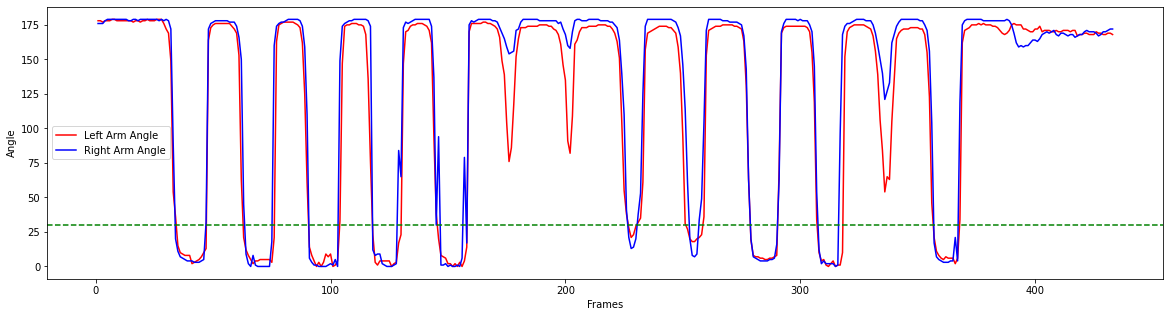

In [8]:
# initialise variables
counter = 0
state = 'Down'
range_flag = True
halfway = False
feedback = ''
frame_count = 0
# Plotting variables
frames = []
left_angle = []
right_angle = []
body_angles = []

# Prompt user input for exercise selection
while True:
    try:
        user_choice = int(input('Which exercise would you like to do? Please enter 1, 2 or 3.\n1. Squat \n2. Arm Curl \n3. Sit-up\n'))
        print("")
        if user_choice in [1, 2, 3]:
            print('Please wait a moment...')
            print('Click on the new window when it appears.\n')
            print('--------------------------------------------------------------------------------------\n')
            break
        else:
            print("Please enter either integer 1, 2 or 3")
            print("")
    except:
        print("Please enter either integer 1, 2 or 3")
        print("")

# Open webcam
feed = cv2.VideoCapture(0)

# Get user's maximum resolution
WIDTH = 10000
HEIGHT = 10000
feed.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
feed.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
width = int(feed.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(feed.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Mediapipe Pose model instance
with mp_pose.Pose(min_detection_confidence=50, min_tracking_confidence=50) as pose:
    while feed.isOpened():
        ret, frame = feed.read()
        frame_count += 1
        frames.append(frame_count)
        # Mirror frame
        frame = cv2.flip(frame, 1)
        # Recolor image from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Pose detection
        detection = pose.process(image)
        # Recolor image from RGB back to BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = True

        # Render detections
        mp_drawing.draw_landmarks(image, detection.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        # Recognise particular exercise based on user input
        if user_choice == 1:
            recognise_squat(detection)
        elif user_choice == 2:
            recognise_curl(detection)
        else:
            recognise_situp(detection)
        

        # Status box setup
        cv2.rectangle(image, (0,0), (width, int(height*0.1)), (245,117,16), -1)
        cv2.putText(image, "REPS:", (int(width*0.01), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, "STATE:", (int(width*0.1), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (int(width*0.2), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, str(counter), (int(width*0.01), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, state, (int(width*0.1), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, feedback, (int(width*0.2), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        window_name = 'Exercise Counter'
        
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.imshow(window_name, image)
        
        # quit webcam
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
cv2.waitKey(1)
feed.release()

plot_viz(user_choice)
print('\nThe red/blue lines show the angle of your targetted body part throughout your exercise,') 
print('whereas the green dotted line is the minimum angle required for the exercise to be recorded as one repetition.') 

--- 
**<div style="text-align: center"> <span style="color:black">That is the end of the program.</span> </div>**
**<div style="text-align: center"> <span style="color:black">Thank you for using our program!</span> </div>**
<div style="text-align: center"> <span style="color:black">You can restart the program (Kernel -> Restart and Run all) if you want to track your next exercise. </span> </div>